# HW3: Ridge

In [1]:
import pandas as pd

# Read the csv files
x_train_scale = pd.read_csv('x_train_scale.csv')
y_train_scale = pd.read_csv('y_train_scale.csv')
x_test_scale = pd.read_csv('x_test_scale.csv')
y_test_scale = pd.read_csv('y_test_scale.csv')

In [2]:
# Show the first 5 rows of the dataframes
print("x_train_scale:")
print(x_train_scale.head())
print("\ny_train_scale:")
print(y_train_scale.head())
print("\nx_test_scale:")
print(x_test_scale.head())
print("\ny_test_scale:")
print(y_test_scale.head())


x_train_scale:
   subject#       age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  \
0         6 -0.198540    0  -1.638719   0.619703     0.740882    0.805863   
1        40  2.290131    1   0.655123  -0.298646    -0.402497   -0.371813   
2        42 -0.424783    0   1.200335  -0.401872    -0.334106   -0.355812   
3        20  0.253946    0  -1.517513  -0.341360    -0.450510   -0.269406   
4         4  1.045796    0   0.280279   0.011030    -0.013089    0.060215   

   Jitter:PPQ5  Jitter:DDP   Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
0     0.477598    0.805846  0.386256     0.327007      0.627476      0.221878   
1    -0.324201   -0.370755  0.008842    -0.054711      0.000760      0.096563   
2    -0.302748   -0.356888 -0.303740    -0.384378     -0.273194     -0.258995   
3    -0.283977   -0.270483 -0.366642    -0.349676     -0.345998     -0.333344   
4    -0.026543    0.061270  1.407744     1.424449      1.646735      1.797604   

   Shimmer:APQ11  Shimmer:DDA      

## Ridge Regression with motor_UPDRS

In [3]:
# pip install statsmodels

In [4]:
import statsmodels.api as sm

# Drop column "subject#" and "test_time" from the independent variable matrix
X = x_train_scale.drop(['subject#', 'test_time'], axis=1)

# Add a constant to the independent variable matrix
X_with_const = sm.add_constant(X)

# Use "motor_UPDRS" as the dependent variable
y = y_train_scale['motor_UPDRS']


### Fit Ridge Regression Model with Cross-validation

The objective of ridge regression is to minimize the following cost function:

$$\text{Cost function} = \left\lVert \boldsymbol{Y} - \boldsymbol{X}\boldsymbol{\beta} \right\rVert^2 + \lambda\left\lVert \boldsymbol{\beta} \right\rVert^2$$

Where:
- $\boldsymbol{Y}$ is the vector of observed values.
- $\boldsymbol{X}$ is the matrix of input features.
- $\boldsymbol{\beta}$ is the vector of coefficients.
- $\boldsymbol{\lambda}$ is the regularization parameter (also known as alpha in `sklearn.linear_model`).
- $\left\lVert \boldsymbol{Y} - \boldsymbol{X}\boldsymbol{\beta} \right\rVert^2$ is the sum of the squared residuals (or mean squared error).
- $\left\lVert \boldsymbol{\beta} \right\rVert^2$ is the sum of the squared coefficients, serving as the regularization term.


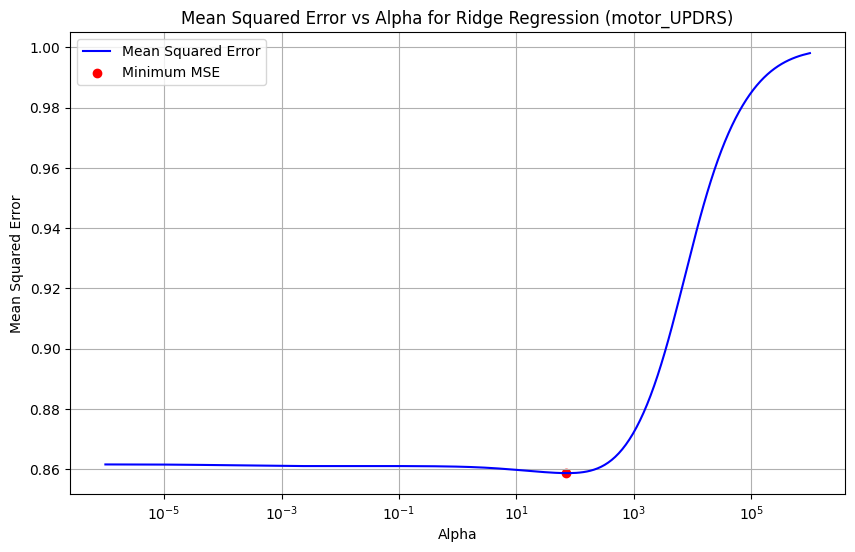

(69.05513520162316, 0.8586981381181898)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold

# Function to calculate MSE with Ridge regression for a given alpha
def ridge_mse_cv(alpha, X, y):
    model = Ridge(alpha=alpha)
    # Define the 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    mse = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    return mse.mean()

# Define a wider range of alpha values to test
alphas_to_test = np.logspace(-6, 6, 200)

# Calculate MSE for each alpha using the defined function and 10-fold CV
mse_scores = [ridge_mse_cv(alpha, X_with_const, y) for alpha in alphas_to_test]

# Find the alpha with the minimum MSE
min_mse_index = np.argmin(mse_scores)
best_alpha_mse = alphas_to_test[min_mse_index]
min_mse = mse_scores[min_mse_index]

# Plot the ridge trace plot
plt.figure(figsize=(10, 6))
plt.semilogx(alphas_to_test, mse_scores, label='Mean Squared Error', color='blue')
plt.scatter(best_alpha_mse, min_mse, color='red', label='Minimum MSE')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Alpha for Ridge Regression (motor_UPDRS)')
plt.legend()
plt.grid(True)
plt.show()

(best_alpha_mse, min_mse)


From the output above, the optimal choice of $\lambda$ is around 69, and the corresponding training MSE in cross-validataion is around 0.859.

In [10]:
# Initialize the Ridge regression model with the best alpha found
best_ridge_model = Ridge(alpha=best_alpha_mse)

# Fit the model with the training data
best_ridge_model.fit(X_with_const, y)

# Predict on the test dataset
# But first, we must prepare the test data like the training data, by dropping the same columns and adding a constant
X_test = x_test_scale.drop(['subject#', 'test_time'], axis=1)
X_test_with_const = sm.add_constant(X_test)
y_test = y_test_scale['motor_UPDRS']

# Make predictions
y_pred = best_ridge_model.predict(X_test_with_const)

# Calculate the Mean Squared Error (MSE) on the test set
test_mse = np.mean((y_test - y_pred) ** 2)
test_mse


0.8862549093221856

The Mean Squared Error (MSE) on the testing data using the best Ridge regression model (with the optimal alpha of approximately 69) is around 0.8863.

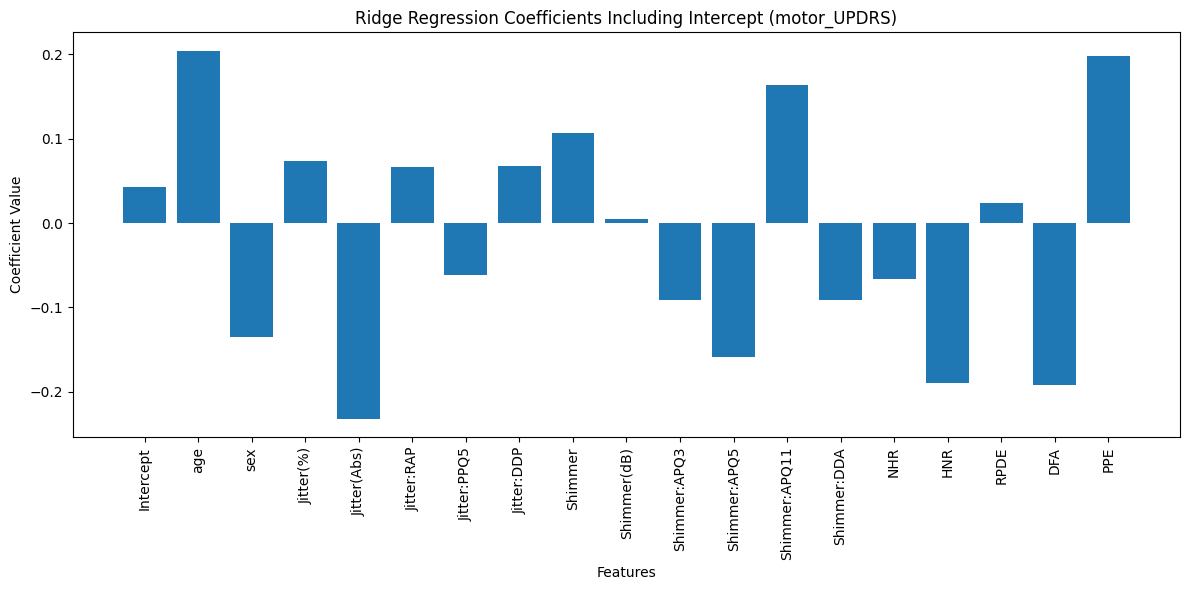

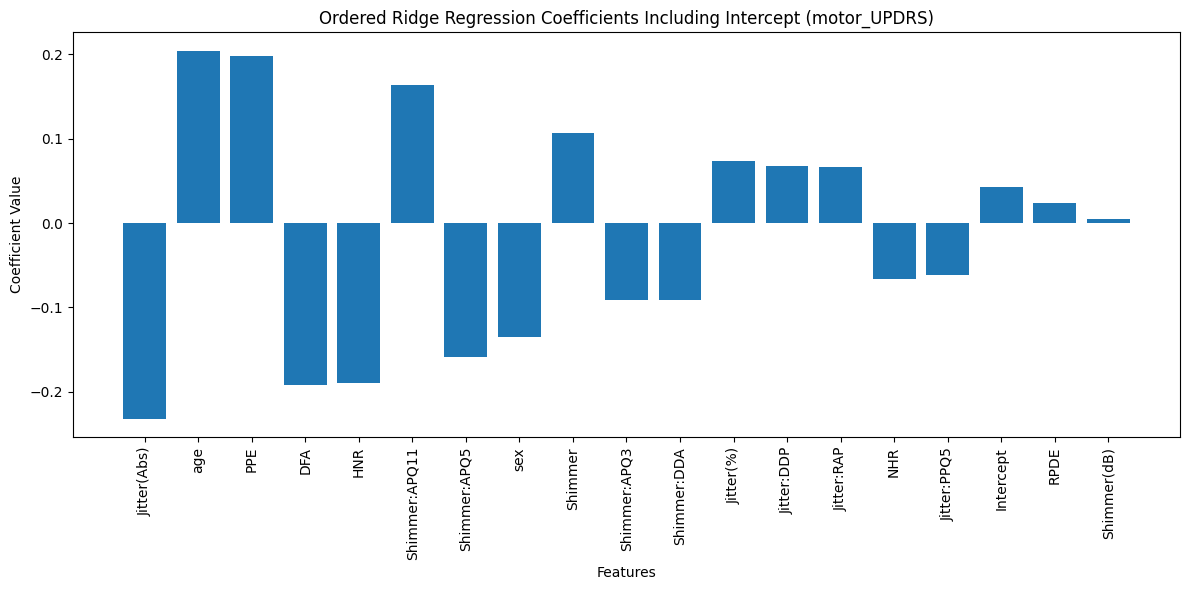

coefficients:
          Feature  Coefficient  abs_coefficient
0       Intercept     0.042324         0.042324
1             age     0.204252         0.204252
2             sex    -0.135046         0.135046
3       Jitter(%)     0.073461         0.073461
4     Jitter(Abs)    -0.232148         0.232148
5      Jitter:RAP     0.066168         0.066168
6     Jitter:PPQ5    -0.062228         0.062228
7      Jitter:DDP     0.067394         0.067394
8         Shimmer     0.106944         0.106944
9     Shimmer(dB)     0.004543         0.004543
10   Shimmer:APQ3    -0.091217         0.091217
11   Shimmer:APQ5    -0.158889         0.158889
12  Shimmer:APQ11     0.163300         0.163300
13    Shimmer:DDA    -0.091072         0.091072
14            NHR    -0.065817         0.065817
15            HNR    -0.190063         0.190063
16           RPDE     0.023463         0.023463
17            DFA    -0.192628         0.192628
18            PPE     0.198436         0.198436


sorted coefficients:
   

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'best_ridge_model' is your trained Ridge model and 'X' is your feature matrix without the intercept

# Extract the coefficients from the model, excluding the extraneous zero if it's there
ridge_coefficients = best_ridge_model.coef_[1:]  # Adjust indexing if needed

# Get the intercept from the model
intercept = best_ridge_model.intercept_

# Combine the intercept with the coefficients
coefficients_with_intercept = np.hstack([intercept, ridge_coefficients])

# Create a DataFrame for the coefficients including the intercept
coefficients_df = pd.DataFrame({
    'Feature': ['Intercept'] + X.columns.tolist(),
    'Coefficient': coefficients_with_intercept
})

# Plot the coefficients in their original order
plt.figure(figsize=(12, 6))
plt.bar(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.title('Ridge Regression Coefficients Including Intercept (motor_UPDRS)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Now sort the coefficients by their absolute values in descending order
coefficients_df['abs_coefficient'] = coefficients_df['Coefficient'].abs()
sorted_coefficients_df = coefficients_df.sort_values(by='abs_coefficient', ascending=False).drop(columns=['abs_coefficient'])

# Plot the sorted coefficients
plt.figure(figsize=(12, 6))
plt.bar(sorted_coefficients_df['Feature'], sorted_coefficients_df['Coefficient'])
plt.title('Ordered Ridge Regression Coefficients Including Intercept (motor_UPDRS)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the coefficients in their original order
print('coefficients:')
print(coefficients_df)
print('\n')

# Print the sorted coefficients
print('sorted coefficients:')
print(sorted_coefficients_df)


### Relative Tests

Tests for normality:

$$ H_0: \text{The residuals are normally distributed}.$$

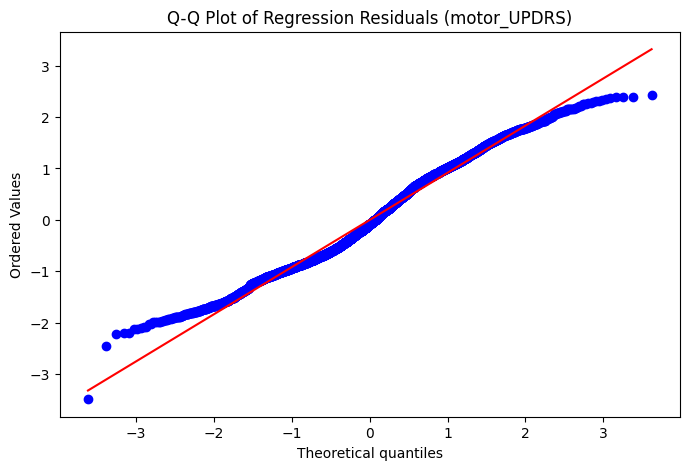

{'Shapiro-Wilk Test Statistic': 0.9840129306476827, 'p-value': 1.183936062196492e-22}


In [24]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate residuals from the best Ridge regression model using the training data
residuals_training = y - best_ridge_model.predict(X_with_const)

# Q-Q plot for the residuals to check for normality using the training data
plt.figure(figsize=(8, 5))
stats.probplot(residuals_training, dist="norm", plot=plt)
plt.title('Q-Q Plot of Regression Residuals (motor_UPDRS)')
plt.show()

# Shapiro-Wilk test for normality of residuals on the training data
shapiro_test_training = stats.shapiro(residuals_training)
shapiro_test_training_results = {
    'Shapiro-Wilk Test Statistic': shapiro_test_training[0],
    'p-value': shapiro_test_training[1]
}
print(shapiro_test_training_results)


From the Q-Q plot, we can see that residuals in the tails deviate significantly from the normal distribution. The result of Shapiro-Wilk test also shows that the normality within the residuals is not satisfied.

Tests for heteroskedasticity:

$$ H_0: \text{The variance of the residuals is constant}.$$

In [16]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Calculate residuals from the Ridge regression model
ridge_residuals = y - best_ridge_model.predict(X_with_const)

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(ridge_residuals, X_with_const)

bp_test_result = {
    'Lagrange Multiplier statistic': bp_test[0],
    'p-value': bp_test[1],
    'f-value': bp_test[2],
    'f p-value': bp_test[3],
}

print(bp_test_result)


{'Lagrange Multiplier statistic': 146.6264837293097, 'p-value': 3.3558030606401185e-22, 'f-value': 8.374237595296904, 'f p-value': 1.3819904732715152e-22}


We run Breusch-Pagan test to test if the variances of the residuals are the same. The result significantly refuses the null hypothesis of homoskedasticity.

### Plotting

We plot the prediction $\hat{y}_i$ against $y_i$.

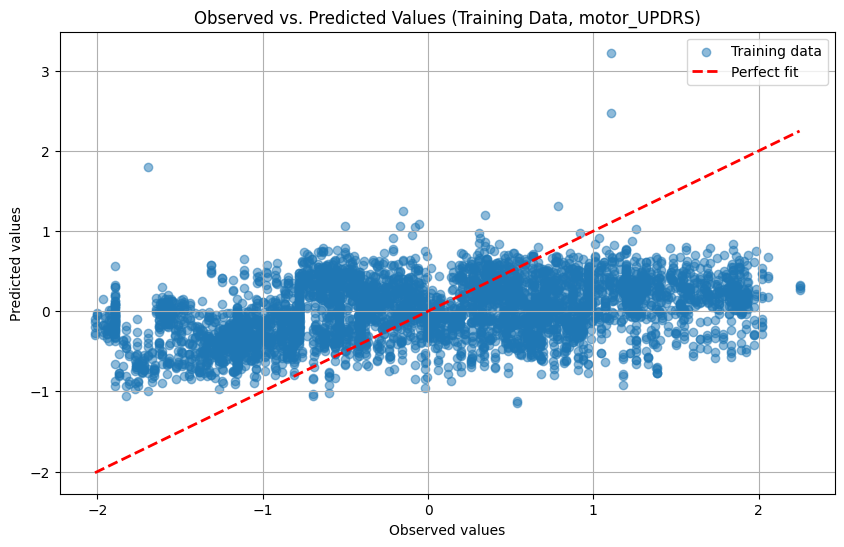

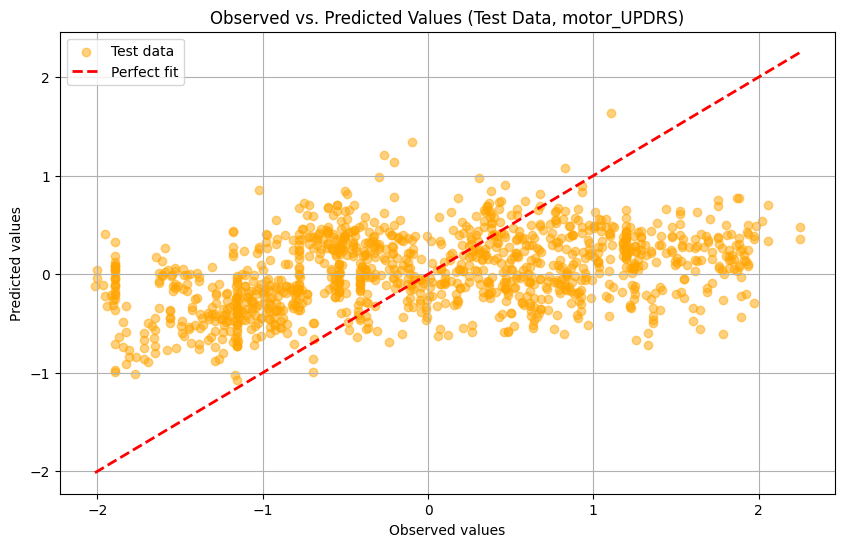

In [17]:
import matplotlib.pyplot as plt

# Predictions on training data
y_train_pred = best_ridge_model.predict(X_with_const)

# Plot for training data
plt.figure(figsize=(10, 6))
plt.scatter(y, y_train_pred, alpha=0.5, label='Training data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2, label='Perfect fit')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Observed vs. Predicted Values (Training Data, motor_UPDRS)')
plt.legend()
plt.grid(True)
plt.show()

# Predictions on test data
y_test_pred = best_ridge_model.predict(X_test_with_const)

# Plot for test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test data', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect fit')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Observed vs. Predicted Values (Test Data, motor_UPDRS)')
plt.legend()
plt.grid(True)
plt.show()


The plot shows that the data points (both the training data and the testing data) clearly deviate from the line of perfect fit.

## Ridge Regression with total_UPDRS

In [25]:
# Use "total_UPDRS" as the dependent variable
y = y_train_scale['total_UPDRS']


### Fit Ridge Regression Model with Cross-validation

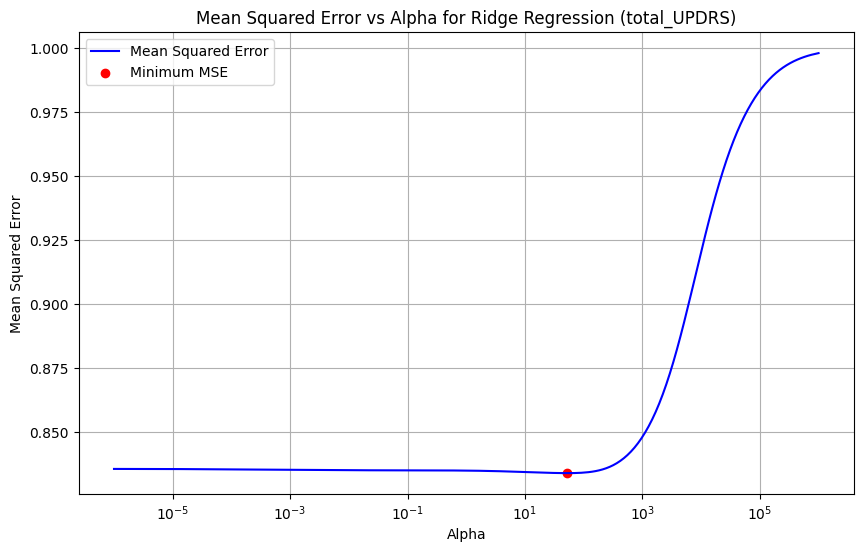

(52.31099308056258, 0.8340776090480688)

In [26]:
# Define a wider range of alpha values to test
alphas_to_test = np.logspace(-6, 6, 200)

# Calculate MSE for each alpha using the defined function and 10-fold CV
mse_scores = [ridge_mse_cv(alpha, X_with_const, y) for alpha in alphas_to_test]

# Find the alpha with the minimum MSE
min_mse_index = np.argmin(mse_scores)
best_alpha_mse = alphas_to_test[min_mse_index]
min_mse = mse_scores[min_mse_index]

# Plot the ridge trace plot
plt.figure(figsize=(10, 6))
plt.semilogx(alphas_to_test, mse_scores, label='Mean Squared Error', color='blue')
plt.scatter(best_alpha_mse, min_mse, color='red', label='Minimum MSE')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Alpha for Ridge Regression (total_UPDRS)')
plt.legend()
plt.grid(True)
plt.show()

(best_alpha_mse, min_mse)


From the output above, the optimal choice of $\lambda$ is around 52, and the corresponding training MSE in cross-validataion is around 0.834.

In [27]:
# Initialize the Ridge regression model with the best alpha found
best_ridge_model = Ridge(alpha=best_alpha_mse)

# Fit the model with the training data
best_ridge_model.fit(X_with_const, y)

# Predict on the test dataset
# But first, we must prepare the test data like the training data, by dropping the same columns and adding a constant
X_test = x_test_scale.drop(['subject#', 'test_time'], axis=1)
X_test_with_const = sm.add_constant(X_test)
y_test = y_test_scale['total_UPDRS']

# Make predictions
y_pred = best_ridge_model.predict(X_test_with_const)

# Calculate the Mean Squared Error (MSE) on the test set
test_mse = np.mean((y_test - y_pred) ** 2)
test_mse


0.8560896809132083

The Mean Squared Error (MSE) on the testing data using the best Ridge regression model (with the optimal alpha of approximately 69) is around 0.8561.

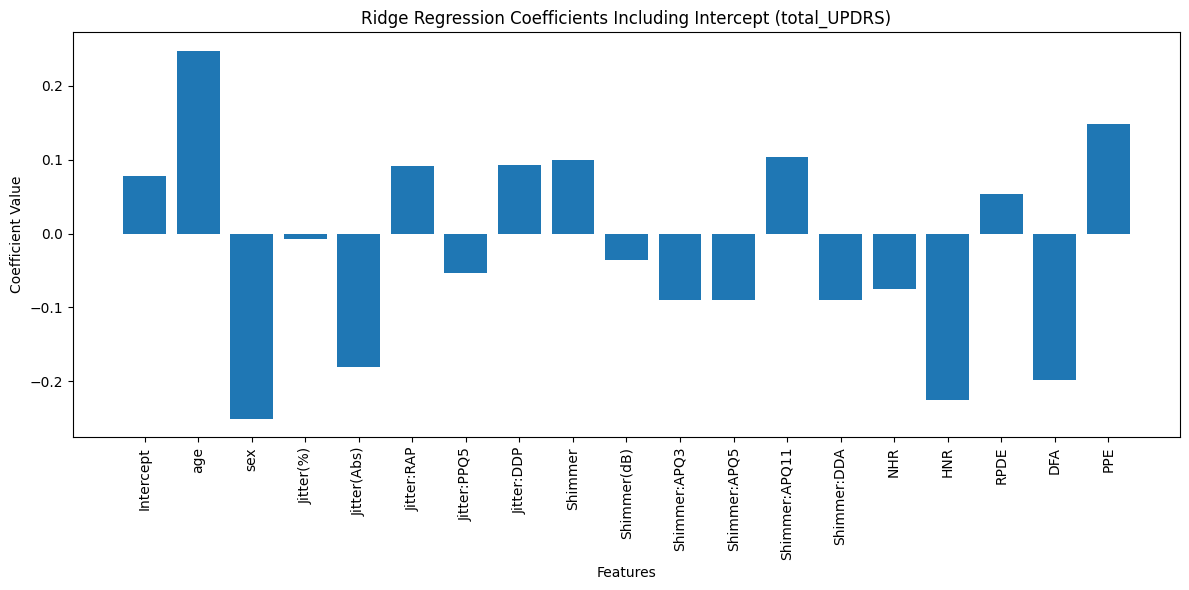

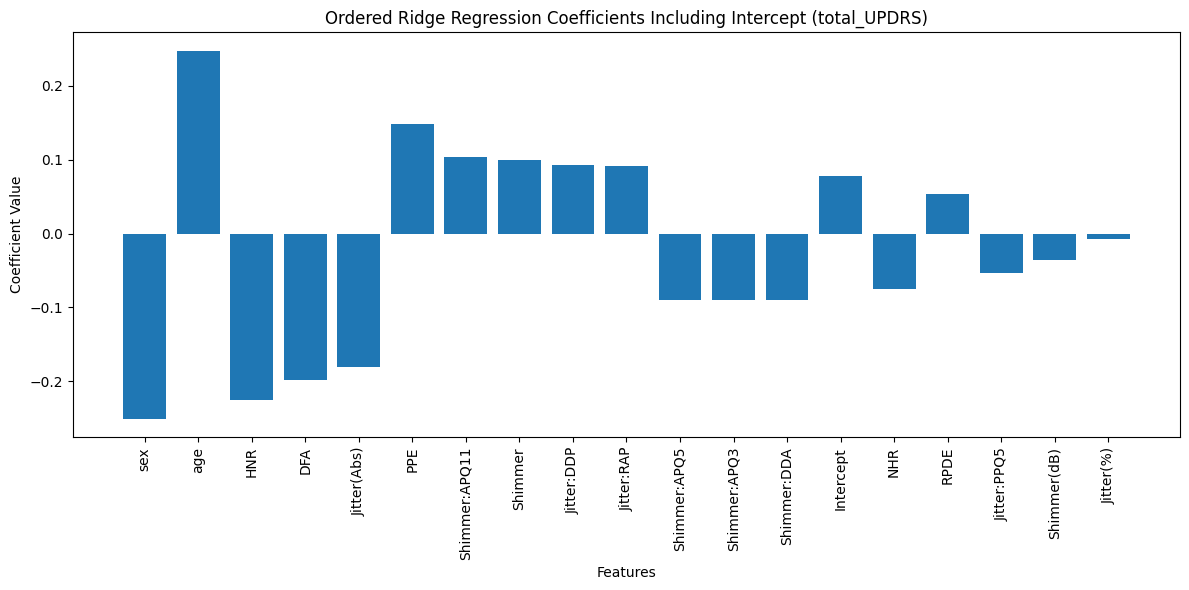

coefficients:
          Feature  Coefficient  abs_coefficient
0       Intercept     0.078657         0.078657
1             age     0.247703         0.247703
2             sex    -0.250976         0.250976
3       Jitter(%)    -0.006832         0.006832
4     Jitter(Abs)    -0.180961         0.180961
5      Jitter:RAP     0.091387         0.091387
6     Jitter:PPQ5    -0.052797         0.052797
7      Jitter:DDP     0.092577         0.092577
8         Shimmer     0.099409         0.099409
9     Shimmer(dB)    -0.035996         0.035996
10   Shimmer:APQ3    -0.089959         0.089959
11   Shimmer:APQ5    -0.089960         0.089960
12  Shimmer:APQ11     0.104195         0.104195
13    Shimmer:DDA    -0.089663         0.089663
14            NHR    -0.074553         0.074553
15            HNR    -0.224856         0.224856
16           RPDE     0.053956         0.053956
17            DFA    -0.198365         0.198365
18            PPE     0.148272         0.148272


sorted coefficients:
   

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'best_ridge_model' is your trained Ridge model and 'X' is your feature matrix without the intercept

# Extract the coefficients from the model, excluding the extraneous zero if it's there
ridge_coefficients = best_ridge_model.coef_[1:]  # Adjust indexing if needed

# Get the intercept from the model
intercept = best_ridge_model.intercept_

# Combine the intercept with the coefficients
coefficients_with_intercept = np.hstack([intercept, ridge_coefficients])

# Create a DataFrame for the coefficients including the intercept
coefficients_df = pd.DataFrame({
    'Feature': ['Intercept'] + X.columns.tolist(),
    'Coefficient': coefficients_with_intercept
})

# Plot the coefficients in their original order
plt.figure(figsize=(12, 6))
plt.bar(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.title('Ridge Regression Coefficients Including Intercept (total_UPDRS)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Now sort the coefficients by their absolute values in descending order
coefficients_df['abs_coefficient'] = coefficients_df['Coefficient'].abs()
sorted_coefficients_df = coefficients_df.sort_values(by='abs_coefficient', ascending=False).drop(columns=['abs_coefficient'])

# Plot the sorted coefficients
plt.figure(figsize=(12, 6))
plt.bar(sorted_coefficients_df['Feature'], sorted_coefficients_df['Coefficient'])
plt.title('Ordered Ridge Regression Coefficients Including Intercept (total_UPDRS)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the coefficients in their original order
print('coefficients:')
print(coefficients_df)
print('\n')

# Print the sorted coefficients
print('sorted coefficients:')
print(sorted_coefficients_df)


### Relative Tests

Tests for normality:

$$ H_0: \text{The residuals are normally distributed}.$$

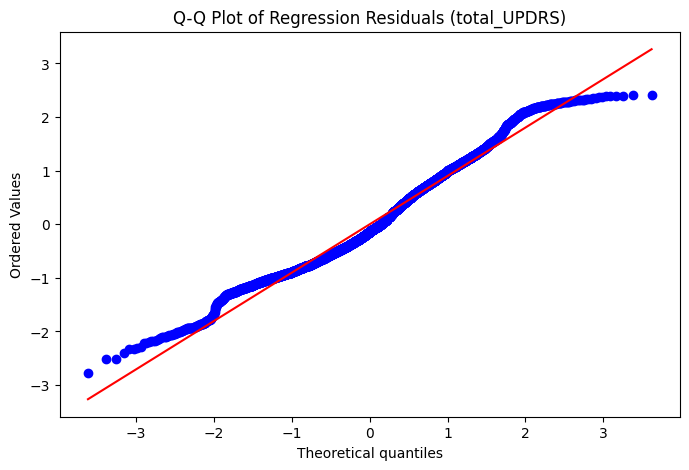

{'Shapiro-Wilk Test Statistic': 0.9795622512026707, 'p-value': 1.7370465046811804e-25}


In [28]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate residuals from the best Ridge regression model using the training data
residuals_training = y - best_ridge_model.predict(X_with_const)

# Q-Q plot for the residuals to check for normality using the training data
plt.figure(figsize=(8, 5))
stats.probplot(residuals_training, dist="norm", plot=plt)
plt.title('Q-Q Plot of Regression Residuals (total_UPDRS)')
plt.show()

# Shapiro-Wilk test for normality of residuals on the training data
shapiro_test_training = stats.shapiro(residuals_training)
shapiro_test_training_results = {
    'Shapiro-Wilk Test Statistic': shapiro_test_training[0],
    'p-value': shapiro_test_training[1]
}
print(shapiro_test_training_results)


From the Q-Q plot, we can see that residuals in the tails deviate significantly from the normal distribution. The result of Shapiro-Wilk test also shows that the normality within the residuals is not satisfied.

Tests for heteroskedasticity:

$$ H_0: \text{The variance of the residuals is constant}.$$

In [23]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Calculate residuals from the Ridge regression model
ridge_residuals = y - best_ridge_model.predict(X_with_const)

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(ridge_residuals, X_with_const)

bp_test_result = {
    'Lagrange Multiplier statistic': bp_test[0],
    'p-value': bp_test[1],
    'f-value': bp_test[2],
    'f p-value': bp_test[3],
}

print(bp_test_result)


{'Lagrange Multiplier statistic': 233.30303056947363, 'p-value': 1.990944653841332e-39, 'f-value': 13.583135288283158, 'f p-value': 1.583661672091523e-40}


We run Breusch-Pagan test to test if the variances of the residuals are the same. The result significantly refuses the null hypothesis of homoskedasticity.

### Plotting

We plot the prediction $\hat{y}_i$ against $y_i$.

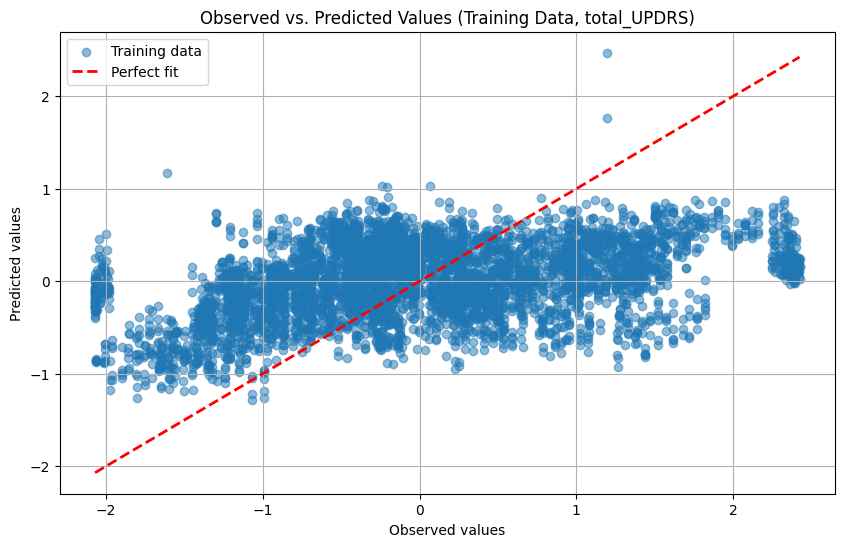

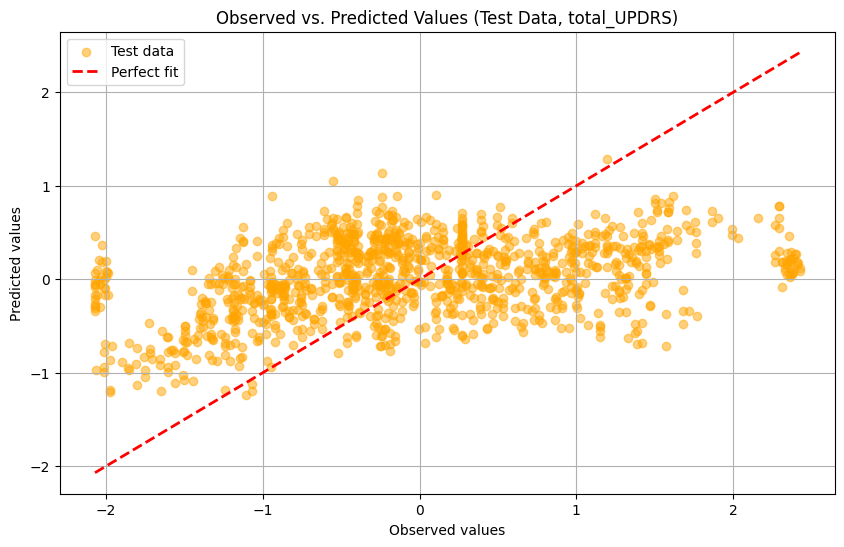

In [24]:
import matplotlib.pyplot as plt

# Predictions on training data
y_train_pred = best_ridge_model.predict(X_with_const)

# Plot for training data
plt.figure(figsize=(10, 6))
plt.scatter(y, y_train_pred, alpha=0.5, label='Training data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2, label='Perfect fit')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Observed vs. Predicted Values (Training Data, total_UPDRS)')
plt.legend()
plt.grid(True)
plt.show()

# Predictions on test data
y_test_pred = best_ridge_model.predict(X_test_with_const)

# Plot for test data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test data', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Perfect fit')
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Observed vs. Predicted Values (Test Data, total_UPDRS)')
plt.legend()
plt.grid(True)
plt.show()


The plot shows that the data points (both the training data and the testing data) clearly deviate from the line of perfect fit.